# Implementation of ***CatBoost***
This notebook demonstrates the implementation of the **CatBoost** for Parkinson’s Disease detection using three feature processing methods:  
1. All Features (`Toutes caractéristiques`).  
2. Feature Selection (`La Sélection des caractéristiques`): ***Wrapper***, ***Embedding***, and ***ANOVA***.  
3. Dimensionality Reduction (`Réduction des données`) using ***PCA***.  

Each method is applied in two ways:  
- Using standard libraries.  
- Using custom implementations developed from scratch.  

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

 


from catboost import CatBoostClassifier
from Models.catboost import CatBoostScratch



## 1. Data Preprocessing  
- **Dataset**: Parkinson's Disease Classification (UCI Machine Learning Repository).  
- **Steps**:  
  1. Load and explore the dataset.  
  2. Handle missing values.  
  3. Normalize features using MinMaxScaler.  
  4. Balance classes using SMOTE.  
- Code snippets for preprocessing are shared below.


In [13]:

# Load the data
data = pd.read_csv("pd_speech_features.csv", header=1)


# Preprocess numeric columns
def safe_convert_numeric(df):
    numeric_columns = df.select_dtypes(include=['object']).columns
    for col in numeric_columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except Exception as e:
            print(f"Error converting column {col}: {e}")
    return df

data = safe_convert_numeric(data)

# Scale the features
scaler = StandardScaler()

# Identify numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns[1:-1]
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Identify binary/categorical columns and other features
binary_features = ['gender']  # Adjust if needed
other_features = [col for col in data.columns if col not in binary_features + ['id', 'class']]

# Aggregate features with mean and std
aggregated_data = data.groupby('id')[other_features].agg(['mean', 'std']).reset_index()

# Flatten multi-level column names
aggregated_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in aggregated_data.columns]

# Add binary features back as-is
for feature in binary_features:
    aggregated_data[feature] = data.groupby('id')[feature].first().values.astype(data[feature].dtype)

# Add the target variable
aggregated_data['class'] = data.groupby('id')['class'].first().values

# Separate features and target
X = aggregated_data.drop(['class', 'id_'], axis=1)
y = aggregated_data['class']


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



## 2.1 Method 1: Using All Features  
This section applies the ***CatBoost*** on the dataset using all features without any feature selection.  

### Implementation Approaches:  
1. **Using Standard Libraries** (e.g., scikit-learn, CatBoost).  
2. **Custom Implementation** of **CatBoost**  

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.


In [14]:
# train using catqboostClassifier

cat_all = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=5,
    loss_function='Logloss',
    verbose=False
)

cat_all.fit(X_train, y_train)

y_pred_all_cat = cat_all.predict(X_test)


In [15]:
# Evaluate the model

print("CatBoost Classifier:")
cat_all_accuracy = accuracy_score(y_test, y_pred_all_cat)
print(f"Accuracy: {cat_all_accuracy}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred_all_cat)}")
print(f"Classification report:\n{classification_report(y_test, y_pred_all_cat)}")
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_all_cat)}")

CatBoost Classifier:
Accuracy: 0.7843137254901961
Confusion matrix:
[[ 4  9]
 [ 2 36]]
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.80      0.95      0.87        38

    accuracy                           0.78        51
   macro avg       0.73      0.63      0.64        51
weighted avg       0.77      0.78      0.75        51

ROC AUC score: 0.6275303643724697


In [16]:
# train using catboostscratch

cat_scratch_all = CatBoostScratch(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.1,
)

cat_scratch_all.fit(X_train, y_train)

# Predict
y_pred_cat_scratch_selected = cat_scratch_all.predict(X_test)

# Evaluate
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_cat_scratch_selected))

print("\nAccuracy score:")
cat_scratch_all_accuracy = accuracy_score(y_test, y_pred_cat_scratch_selected)
print(cat_scratch_all_accuracy)

print("\nClassification report:")
print(classification_report(y_test, y_pred_cat_scratch_selected))


Confusion matrix:
[[ 5  8]
 [ 3 35]]

Accuracy score:
0.7843137254901961

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.38      0.48        13
           1       0.81      0.92      0.86        38

    accuracy                           0.78        51
   macro avg       0.72      0.65      0.67        51
weighted avg       0.77      0.78      0.77        51



## 2.2 Method 2: Feature Selection  
Features are selected using three techniques: Wrapper, Embedding, and ANOVA. The union of selected features is used for model training.  

### Sub-methods:  
1. **Wrapper Method**: Backward elimination.  
2. **Embedding Method**: LassoCV.  
3. **ANOVA**: Statistical test for feature importance.  

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.


In [17]:
from SelectionType.EFSA.main import FeatureSelector

# Initialize the Feature Selector
selector = FeatureSelector(X_train, y_train)
# Perform feature selection based on anova embedding and wrapper methods
selected_features = selector.comprehensive_feature_selection(k_features=80) 

print(f"\nSelected Features: {selected_features}")


Selected Features: ['tqwt_kurtosisValue_dec_36_mean', 'tqwt_TKEO_std_dec_11_mean', 'tqwt_stdValue_dec_19_std', 'tqwt_kurtosisValue_dec_18_mean', 'std_delta_delta_log_energy_mean', 'det_LT_entropy_log_6_coef_mean', 'det_LT_entropy_shannon_8_coef_mean', 'tqwt_skewnessValue_dec_30_std', 'tqwt_entropy_shannon_dec_20_std', 'tqwt_minValue_dec_11_mean', 'det_LT_entropy_log_4_coef_mean', 'tqwt_stdValue_dec_12_mean', 'tqwt_stdValue_dec_10_mean', 'det_LT_entropy_log_3_coef_std', 'mean_MFCC_6th_coef_mean', 'det_LT_entropy_log_3_coef_mean', 'det_LT_entropy_shannon_8_coef_std', 'tqwt_maxValue_dec_13_mean', 'std_6th_delta_delta_mean', 'tqwt_kurtosisValue_dec_26_mean', 'tqwt_kurtosisValue_dec_27_mean', 'gender', 'tqwt_stdValue_dec_11_mean', 'tqwt_kurtosisValue_dec_34_mean', 'tqwt_minValue_dec_10_mean', 'det_LT_entropy_shannon_10_coef_std', 'tqwt_medianValue_dec_31_std', 'std_8th_delta_delta_mean', 'tqwt_TKEO_mean_dec_21_mean', 'det_LT_entropy_log_6_coef_std', 'tqwt_TKEO_mean_dec_26_std', 'det_LT_ent

In [18]:
# train catboost using selected features
cat_selected = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=5,
    loss_function='Logloss',
    verbose=False
)

cat_selected.fit(X_train[selected_features], y_train)

y_pred_selected_cat = cat_selected.predict(X_test[selected_features])

# Evaluate
print("CatBoost Classifier with selected features:")
cat_selected_accuracy = accuracy_score(y_test, y_pred_selected_cat)
print(f"Accuracy: {cat_selected_accuracy}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_selected_cat)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_selected_cat)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_selected_cat)}")


CatBoost Classifier with selected features:
Accuracy: 0.7647058823529411
ROC AUC: 0.6396761133603239
Confusion Matrix:
[[ 5  8]
 [ 4 34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        13
           1       0.81      0.89      0.85        38

    accuracy                           0.76        51
   macro avg       0.68      0.64      0.65        51
weighted avg       0.74      0.76      0.75        51



In [19]:
# Training our catboost using the selected features

cat_scratch_selected = CatBoostScratch(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.1,
)

cat_scratch_selected.fit(X_train[selected_features], y_train)

# Predict
y_pred_cat_scratch_selected = cat_scratch_selected.predict(X_test[selected_features])


In [20]:
# Evaluate
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_cat_scratch_selected))

print("\nAccuracy score:")
cat_scratch_selected_accuracy = accuracy_score(y_test, y_pred_cat_scratch_selected)
print(cat_scratch_selected_accuracy)

print("\nClassification report:")
print(classification_report(y_test, y_pred_cat_scratch_selected))



Confusion matrix:
[[ 5  8]
 [ 2 36]]

Accuracy score:
0.803921568627451

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.82      0.95      0.88        38

    accuracy                           0.80        51
   macro avg       0.77      0.67      0.69        51
weighted avg       0.79      0.80      0.78        51



## 2.3 Method 3: Dimensionality Reduction  
Principal Component Analysis (PCA) is used to reduce the dataset's dimensionality before applying the **CatBoost**.

### Evaluation Metrics:  
- Accuracy, Precision, Recall, F1-Score, ROC-AUC.


In [27]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from SelectionType.acp import PCAFromScratch
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Splitting the data into train and test sets to prevent overfitting

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Initialize SMOTE and PCA
smote = SMOTE(random_state=42)
pca = PCAFromScratch(n_components=80)  # Adjust number of components as needed

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to the scaled dataset
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Ensure data is float type
X_train_pca = X_train_pca.astype(float)
X_test_pca = X_test_pca.astype(float)

# Initialize CatBoost Classifier with regularization and early stopping
cat_pca = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=7,
    use_best_model=True,  # Use the best model during training
    verbose=False
)

# Train the CatBoost Classifier on PCA-transformed data
cat_pca.fit(
    X_train_pca, y_train_smote,
    eval_set=(X_test_pca, y_test),
    plot=False
)

# Predict on the test set
y_pred_cat_pca = cat_pca.predict(X_test_pca)

print("CatBoost Classifier with PCA:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cat_pca)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_cat_pca)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_cat_pca)}")



C:\Users\bouma\AppData\Local\Temp\ipykernel_35160\2251688012.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_pca = X_train_pca.astype(float)
C:\Users\bouma\AppData\Local\Temp\ipykernel_35160\2251688012.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test_pca = X_test_pca.astype(float)


CatBoost Classifier with PCA:
Accuracy: 0.7058823529411765
Confusion Matrix:
[[ 9  4]
 [11 27]]
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.69      0.55        13
           1       0.87      0.71      0.78        38

    accuracy                           0.71        51
   macro avg       0.66      0.70      0.66        51
weighted avg       0.76      0.71      0.72        51



In [22]:
cat_scratch_pca = CatBoostScratch(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.1,
)

cat_scratch_pca.fit(X_train_pca, y_train_smote)

# Predict
y_pred_cat_scratch_pca = cat_scratch_pca.predict(X_test_pca)

# Evaluate
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_cat_scratch_pca))

print("\nAccuracy score:")
print(accuracy_score(y_test, y_pred_cat_scratch_pca))

print("\nClassification report:")
print(classification_report(y_test, y_pred_cat_scratch_pca))



Confusion matrix:
[[ 6  7]
 [10 28]]

Accuracy score:
0.6666666666666666

Classification report:
              precision    recall  f1-score   support

           0       0.38      0.46      0.41        13
           1       0.80      0.74      0.77        38

    accuracy                           0.67        51
   macro avg       0.59      0.60      0.59        51
weighted avg       0.69      0.67      0.68        51



## 3. Comparative Analysis  
- **Objective**: Compare the performance of the **CatBoost** across:  
  1. All Features.  
  2. Feature Selection.  
  3. PCA.  
- **Comparison Metrics**:  
  - Performance (Accuracy, Precision, Recall, F1-Score, ROC-AUC).  
  - Computational efficiency (Training and Testing Time).  
- Present results as tables and visualizations (e.g., bar plots, ROC curves).  


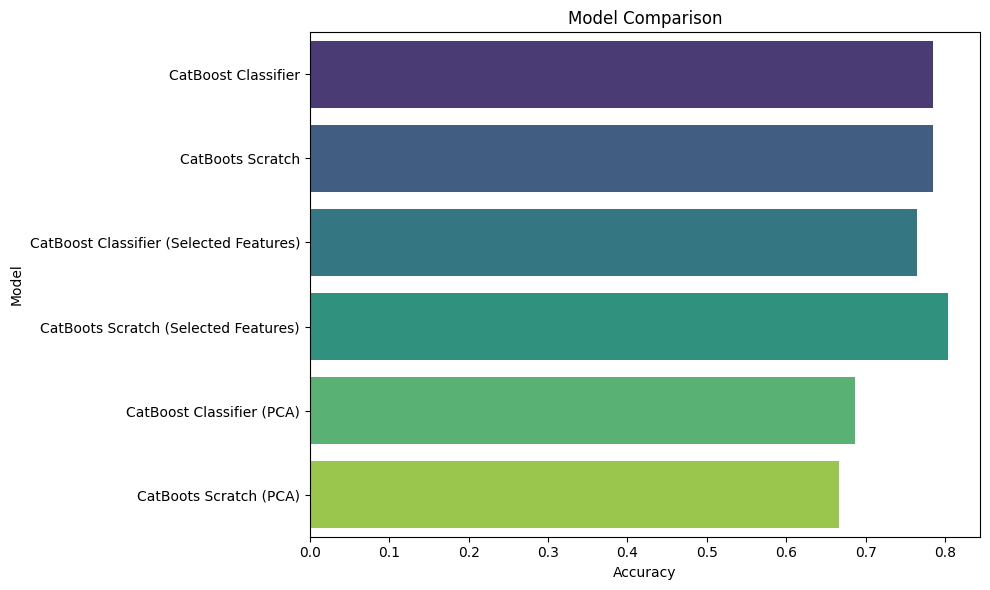

In [26]:
# performace comparison between the two models using all features and selected features and PCA

# Create a DataFrame for the results
results = pd.DataFrame({
    'Model': ['CatBoost Classifier', 'CatBoots Scratch', 'CatBoost Classifier (Selected Features)', 'CatBoots Scratch (Selected Features)', 'CatBoost Classifier (PCA)', 'CatBoots Scratch (PCA)'],
    'Accuracy': [cat_all_accuracy, cat_scratch_all_accuracy, cat_selected_accuracy, cat_scratch_selected_accuracy, accuracy_score(y_test, y_pred_cat_pca), accuracy_score(y_test, y_pred_cat_scratch_pca)]
})

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis', hue='Model')
plt.title('Model Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.tight_layout()
plt.show()
